In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import geo_tools, nc_tools, tidetools, viz_tools
import xarray as xr
import datetime
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
ferry = pd.read_csv('https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV18-01.csv?time%2Clongitude%2Clatitude%2Cchlorophyll&time%3E=2017-01-01T00%3A00%3A00Z&time%3C=2017-12-31T23%3A59%3A00Z&longitude%3E=-123.78116&longitude%3C=-123.694065')
ferry = ferry.drop(ferry.index[0])

In [4]:
ferry.shape

(22878, 4)

In [5]:
ferry[:3]

,time,longitude,latitude,chlorophyll
1,2017-02-15T00:36:00Z,-123.69407221833332,49.19252778166666,NaN
2,2017-02-15T00:37:00Z,-123.70168333,49.195111114999996,NaN
3,2017-02-15T00:38:00Z,-123.70926666500002,49.19772222500001,NaN


In [6]:
ferry[-3:]

,time,longitude,latitude,chlorophyll
22876,2017-12-31T21:16:00Z,-123.71265555166667,49.18855556,NaN
22877,2017-12-31T21:17:00Z,-123.70532221833334,49.18605555833333,NaN
22878,2017-12-31T21:18:00Z,-123.69793333000001,49.18355556,NaN


In [7]:
import pickle

In [8]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [9]:
import os

In [10]:
ferry = ferry.dropna()

In [11]:
ferry.shape

(19836, 4)

In [12]:
list_of_model_chl = np.array([])
list_of_ferry_chl = np.array([])
list_of_date = np.array([])
for n in ferry.index:
    Yind, Xind = geo_tools.find_closest_model_point(float(ferry.longitude[n]), 
                                                    float(ferry.latitude[n]), 
                                                    X, Y, land_mask = bathy.mask)
    date = datetime.datetime.strptime(ferry.time[n][:-1], '%Y-%m-%dT%H:%M:%S')
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
    nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
    if date.minute < 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
        after = before + datetime.timedelta(hours=1)
        sub_dir2 = after.strftime('%d%b%y').lower()
        datestr2 = after.strftime('%Y%m%d')
        fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
        nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
        delta = (date - before).seconds / 3600
        chl_val = 1.6*((1-delta)*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                       + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                       + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                   (delta)*(nuts2.variables['diatoms'][after.hour, 1, Yind, Xind] 
                       + nuts2.variables['ciliates'][after.hour,1,Yind, Xind] 
                       + nuts2.variables['flagellates'][after.hour,1,Yind,Xind]))
    if date.minute >= 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30)
        after = before + datetime.timedelta(hours=1)
        sub_dir2 = after.strftime('%d%b%y').lower()
        datestr2 = after.strftime('%Y%m%d')
        fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
        nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
        delta = (date - before).seconds / 3600
        chl_val = 1.6*((1-delta)*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                       + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                       + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                   (delta)*(nuts2.variables['diatoms'][after.hour, 1, Yind, Xind] 
                       + nuts2.variables['ciliates'][after.hour,1,Yind, Xind] 
                       + nuts2.variables['flagellates'][after.hour,1,Yind,Xind]))
    list_of_ferry_chl = np.append(list_of_ferry_chl, float(ferry.chlorophyll[n]))
    list_of_model_chl = np.append(list_of_model_chl, chl_val)
    list_of_date = np.append(list_of_date, date)

In [72]:
t0=datetime.datetime(2017,1,1)
model_average = np.array([])
for date in [t0+datetime.timedelta(days=ii*1) for ii in range(365)]:
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_1d_{}_{}_ptrc_T.nc'.format(datestr, datestr)
    nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
    chl = (1.6*(nuts.variables['diatoms'][0, 1, 472:481, 237:246] 
               + nuts.variables['ciliates'][0,1,472:481, 237:246] 
               + nuts.variables['flagellates'][0,1,472:481, 237:246])).mean()
    model_average = np.append(model_average, chl)

In [73]:
t0=datetime.datetime(2015,1,1)
model_average_2015 = np.array([])
for date in [t0+datetime.timedelta(days=ii*1) for ii in range(365)]:
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_1d_{}_{}_ptrc_T.nc'.format(datestr, datestr)
    nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
    chl = (1.6*(nuts.variables['diatoms'][0, 1, 472:481, 237:246] 
               + nuts.variables['ciliates'][0,1,472:481, 237:246] 
               + nuts.variables['flagellates'][0,1,472:481, 237:246])).mean()
    model_average_2015 = np.append(model_average_2015, chl)

In [74]:
t0=datetime.datetime(2016,1,1)
model_average_2016 = np.array([])
for date in [t0+datetime.timedelta(days=ii*1) for ii in range(366)]:
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_1d_{}_{}_ptrc_T.nc'.format(datestr, datestr)
    nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
    chl = (1.6*(nuts.variables['diatoms'][0, 1, 472:481, 237:246] 
               + nuts.variables['ciliates'][0,1,472:481, 237:246] 
               + nuts.variables['flagellates'][0,1,472:481, 237:246])).mean()
    model_average_2016 = np.append(model_average_2016, chl)

In [13]:
list_of_days = np.array([list_of_date[n].date() for n in range(list_of_date.shape[0])])
list_of_days.shape

(19836,)

In [14]:
daily_ferry_chl = np.array([])
daily_model_chl = np.array([])
for day in np.unique(list_of_days):
    daily_ferry_chl = np.append(daily_ferry_chl, list_of_ferry_chl[list_of_days == day].mean())
    daily_model_chl = np.append(daily_model_chl, list_of_model_chl[list_of_days == day].mean())

In [24]:
ferry_2015 = pickle.load(open('daily_ferry_chl_2015.pkl', 'rb'))
model_2015 = pickle.load(open('daily_model_chl_2015.pkl', 'rb'))
days_2015 = pickle.load(open('days_2015.pkl', 'rb'))
ferry_2016 = pickle.load(open('daily_ferry_chl_2016.pkl', 'rb'))
model_2016 = pickle.load(open('daily_model_chl_2016.pkl', 'rb'))
days_2016 = pickle.load(open('days_2016.pkl', 'rb'))

In [95]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.titlesize'] = 18

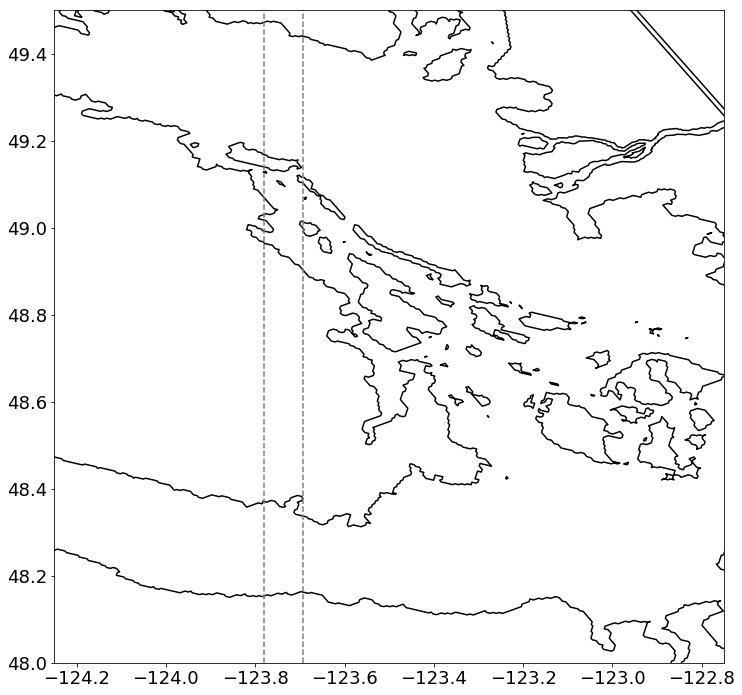

In [96]:
fig, ax = plt.subplots(figsize = (12,12))
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.plot((-123.78116, -123.78116), (48, 50), '--', color = 'grey')
ax.plot((-123.694065, -123.694065), (48, 50), '--', color = 'grey')
ax.set_xlim(-124.25, -122.75)
ax.set_ylim(48, 49.5);

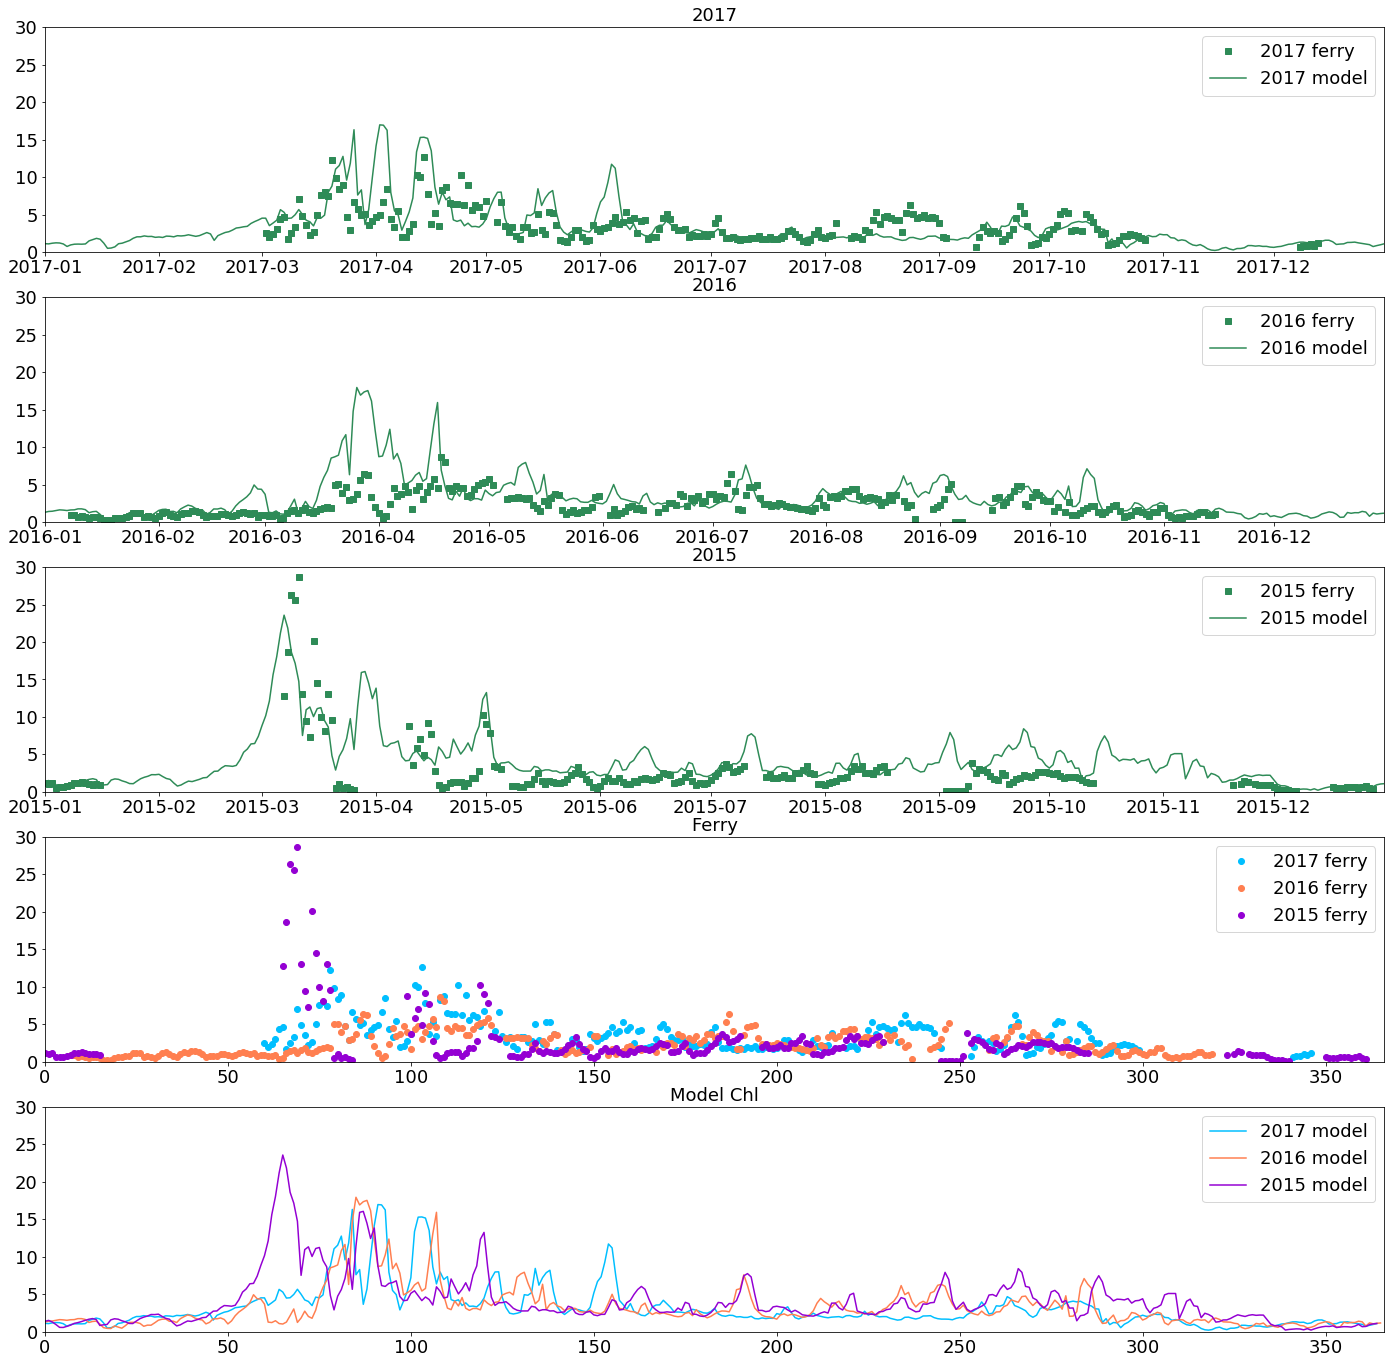

In [108]:
fig, ax = plt.subplots(5,1, figsize = (24,24))
ax[0].plot(np.unique(list_of_days), daily_ferry_chl, 's' , color = 'SeaGreen', label = '2017 ferry')
ax[0].plot([datetime.date(2017,1,1)+datetime.timedelta(days=ii*1) for ii in range(365)], 
                model_average, color = 'SeaGreen', label = '2017 model')
ax[0].set_ylim(0, 30)
ax[0].set_xlim(datetime.date(2017,1,1), datetime.date(2017,12,31))
ax[0].set_title('2017')
ax[0].legend();

ax[1].plot(days_2016, ferry_2016, 's' , color = 'SeaGreen', label = '2016 ferry')
ax[1].plot([datetime.date(2016,1,1)+datetime.timedelta(days=ii*1) for ii in range(366)], 
                model_average_2016, color = 'SeaGreen', label = '2016 model')
ax[1].set_ylim(0, 30)
ax[1].set_xlim(datetime.date(2016,1,1), datetime.date(2016,12,31))
ax[1].set_title('2016')
ax[1].legend();

ax[2].plot(days_2015, ferry_2015, 's', color = 'SeaGreen',
          label = '2015 ferry')
ax[2].plot([datetime.date(2015,1,1)+datetime.timedelta(days=ii*1) for ii in range(365)], 
                model_average_2015,color = 'SeaGreen', label = '2015 model')
ax[2].set_ylim(0, 30)
ax[2].set_xlim(datetime.date(2015,1,1), datetime.date(2015,12,31))
ax[2].set_title('2015')
ax[2].legend();

ax[3].plot([(np.unique(list_of_days) - datetime.date(2017,1,1))[n].days 
            for n in range(np.unique(list_of_days).shape[0])], 
           daily_ferry_chl, 'o' , color = 'DeepSkyBlue', label = '2017 ferry')
ax[3].plot([(days_2016 - datetime.date(2016,1,1))[n].days 
            for n in range(days_2016.shape[0])], 
           ferry_2016, 'o' , color = 'Coral', label = '2016 ferry')
ax[3].plot([(days_2015 - datetime.date(2015,1,1))[n].days 
            for n in range(days_2015.shape[0])], 
           ferry_2015, 'o' , color = 'DarkViolet', label = '2015 ferry')
ax[3].set_ylim(0, 30)
ax[3].set_xlim(0,366)
ax[3].set_title('Ferry')
ax[3].legend();

ax[4].plot(range(365), model_average, color = 'DeepSkyBlue', label = '2017 model')
ax[4].plot(range(366), model_average_2016, color = 'Coral', label = '2016 model')
ax[4].plot(range(365), model_average_2015, color = 'DarkViolet', label = '2015 model')

ax[4].set_ylim(0, 30)
ax[4].set_xlim(0,366)
ax[4].set_title('Model Chl')
ax[4].legend();